In [4]:
## Load modules and data
import numpy as np
import pandas as pd
from tqdm import trange
import matplotlib.pyplot as plt

import sys
sys.path.insert(0, "./src")

from plotting import plot_data, plot_mean_against_index, show_feature, receptive_fields
from persistence import persistence
from decoding import cohomological_parameterization, remove_feature
from noisereduction import PCA_reduction, top_noise_reduction, z_cutoff, density_filtration

## Load stimuli
data_path = "/mnt/c/wsl/projects/top_vision/data/PVCre_2021_0012_s6/"
stimli_columns = ["m", "s", "e", "stim_id", "trial_id", "grat_type", "grat_form",
                "grat_orientation", "grat_contrast", "grat_temp_freq",
                "grat_spat_freq", "grat_direction", "grat_phase", "grat_width",
                "grat_height", "grat_x_position", "grat_y_position",
                "grat_luminance", "trial_on_time", "trial_off_time"]
stimuli = pd.DataFrame(np.load(data_path + "gratings_e14.npy", allow_pickle=True))
stimuli.columns = stimli_columns

## Compute firing rates
# firing_times = np.load(data_path + "spike_times_e14.npy", allow_pickle=True)
# number_of_spikes = np.zeros([len(stimuli), len(firing_times)])
# for neuron in trange(len(firing_times)):
#     for stimulus in range(len(stimuli)):
#         start = stimuli["trial_on_time"][stimulus] + 0.08
#         end = stimuli["trial_off_time"][stimulus] + 0.08
#         number_of_spikes[stimulus][neuron] = (
#                 sum([1 for time in firing_times[neuron] if start < time < end])
#             )
# np.save(data_path + "spike_counts_e14.npy", number_of_spikes)

## Generate dataframe
spike_counts = np.load(data_path + "spike_counts_e14.npy", allow_pickle=True)
orientations = stimuli["grat_orientation"]
phases = stimuli["grat_phase"]
orientations = [ori + 180 if (stimuli["grat_phase"].iloc[i] > 180) else ori for i,ori in enumerate(stimuli["grat_orientation"])] # change coordinates for ori averaging
phases = [180 - phase if (stimuli["grat_phase"].iloc[i] > 180) else phase for i,phase in enumerate(stimuli["grat_phase"])] # change coordinates for ori averaging
index = pd.MultiIndex.from_arrays([orientations, phases])
index.names = ["orientation", "phase"]
spike_counts = pd.DataFrame(spike_counts, index=index)
firing_rates = spike_counts.groupby(["orientation", "phase"]).mean() # TODO: should divide by stimulus length
sem = spike_counts.groupby(["orientation", "phase"]).sem()

data = firing_rates
data = data.groupby(["orientation"]).mean()

In [5]:
phases

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 18.0,
 18.0,
 18.0,
 18.0,
 18.0,
 18.0,
 18.0,
 18.0,
 18.0,
 18.0,
 18.0,
 18.0,
 18.0,
 18.0,
 18.0,
 18.0,
 18.0,
 18.0,
 18.0,
 18.0,
 18.0,
 18.0,
 18.0,
 18.0,
 18.0,
 18.0,
 18.0,
 18.0,
 18.0,
 18.0,
 18.0,
 18.0,
 18.0,
 18.0,
 18.0,
 18.0,
 18.0,
 18.0,
 18.0,
 18.0,
 18.0,
 18.0,
 18.0,
 18.0,
 18.0,
 18.0,
 18.0,
 18.0,
 18.0,
 18.0,
 36.0,
 36.0,
 36.0,
 36.0,
 36.0,
 36.0,
 36.0,
 36.0,
 36.0,
 36.0,
 36.0,
 36.0,
 36.0,
 36.0,
 36.0,
 36.0,
 36.0,
 36.0,
 36.0,
 36.0,
 36.0,
 36.0,
 36.0,
 36.0,
 36.0,
 36.0,
 36.0,
 36.0,
 36.0,
 36.0,
 36.0,
 36.0,
 36.0,
 36.0,
 36.0,
 36.0,
 36.0,
 36.0,
 36.0,
 36.0,
 36.0,
 36.0,
 36.0,
 36.0,
 36.0,
 36.0,
 36.0,
 36.0,
 36.0,
 36.0,


In [ ]:
## Normalize firing rates
for neuron in data.columns:
    data[neuron] = data[neuron] / data[neuron].abs().max()  # TODO: should do z-score instead

In [ ]:
## Apply noise reduction
data = PCA_reduction(data, 10)
# data = z_cutoff(data,2)
# data = top_noise_reduction(data, n=4000, speed=0.02, omega=0.8, fraction=0.9, plot_history=True)
data = density_filtration(data, 15, 0.7)
data_backup = data

/home/loek/miniconda3/envs/top_vision/lib/python3.9/site-packages/ripser/ripser.py:247: UserWarning:

The input matrix is square, but the distance_matrix flag is off.  Did you mean to indicate that this was a distance matrix?



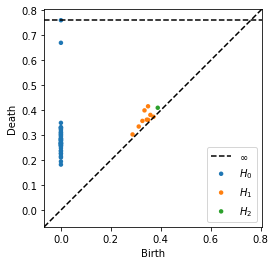

/home/loek/miniconda3/envs/top_vision/lib/python3.9/site-packages/ripser/ripser.py:247: UserWarning:

The input matrix is square, but the distance_matrix flag is off.  Did you mean to indicate that this was a distance matrix?



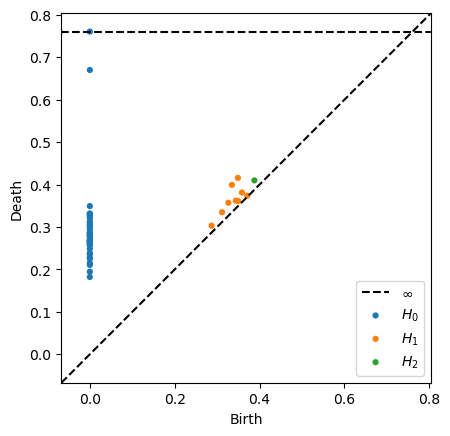

In [2]:
## Analyze shape
persistence(data,homdim=2,coeff=2)
persistence(data,homdim=2,coeff=3)

/home/loek/miniconda3/envs/top_vision/lib/python3.9/site-packages/ripser/ripser.py:247: UserWarning:

The input matrix is square, but the distance_matrix flag is off.  Did you mean to indicate that this was a distance matrix?

/home/loek/miniconda3/envs/top_vision/lib/python3.9/site-packages/ripser/ripser.py:247: UserWarning:

The input matrix is square, but the distance_matrix flag is off.  Did you mean to indicate that this was a distance matrix?



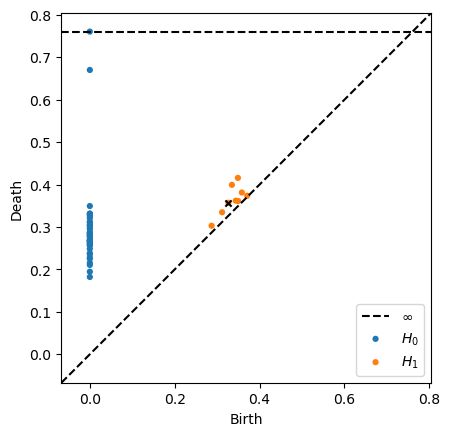

Decoding... done


Averaging images: 100%|██████████| 40/40 [00:00<00:00, 294.22it/s]

Number of images averaged over:
[4. 4. 4. 4. 4. 4. 4. 4. 4. 4.]


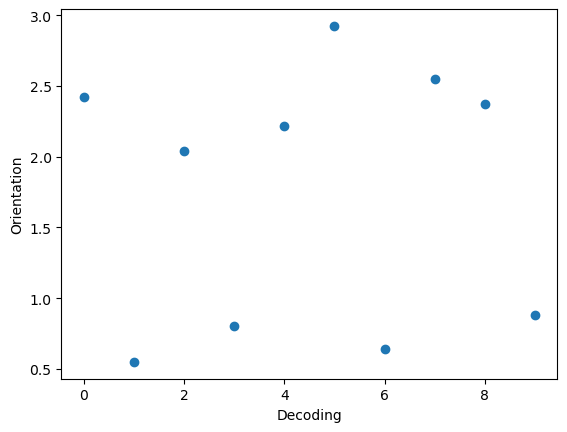

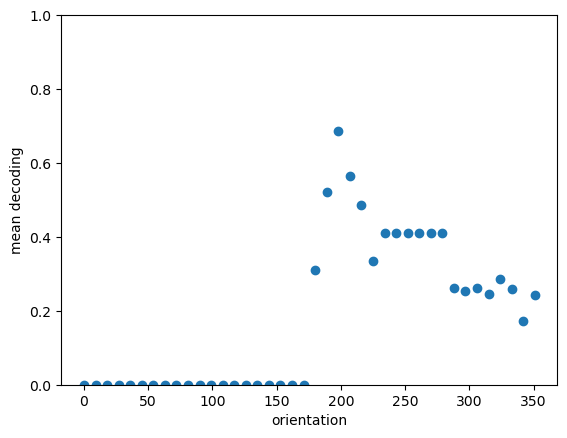

Start : This command cannot be run due to the error: The system cannot find the file specified.
At line:1 char:1
+ Start "/home/loek/projects/top_vision/temp-plot.html"
+ ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    + CategoryInfo          : InvalidOperation: (:) [Start-Process], InvalidOperationException
    + FullyQualifiedErrorId : InvalidOperationException,Microsoft.PowerShell.Commands.StartProcessCommand
 


In [8]:
## Decode first parameter
decoding1 = cohomological_parameterization(data, cocycle_number=3, weighted=False, coeff=23)
# decoding1 = PCA_reduction(data,dim=1)
images = show_feature(decoding1, Nimages=10)
# interactive(lambda n : plt.imshow(images[n], "gray", vmin=-1, vmax=1), n=(0,10-1,1))
plot_mean_against_index(data,decoding1,"orientation")
# plot_mean_against_index(data,decoding1,"phase")
plot_data(data,transformation="PCA", labels=decoding1, colors=["Twilight","Twilight","Twilight"])

In [ ]:
## Decode second parameter
reduced_data = remove_feature(data, decoding1, cut_amplitude=0.5)
decoding2 = cohomological_parameterization(reduced_data, cocycle_number=1, coeff=23)
images = show_feature(decoding2, Nimages=10)
# plot_mean_against_index(data,decoding2,"orientation")
# plot_mean_against_index(data,decoding2,"phase")
plot_data(data,transformation="PCA", labels=decoding2, colors=["Twilight","Twilight","Twilight"])

In [ ]:
## Plot tuning
for (neuron, firing_rates) in data.iteritems():
    firing_rates_ori = firing_rates.groupby("orientation").mean()
    plt.plot(firing_rates_ori)
    plt.title("Orientation")
plt.show()

for (neuron, firing_rates) in data.iteritems():
    firing_rates_ori = firing_rates.groupby("phase").mean()
    plt.plot(firing_rates_ori)
    plt.title("Phase")
plt.show()

# label = "orientation"
# u_label = np.unique(data.reset_index()[label])
# n = len(data.reset_index()[label])/len(u_label)
# for (neuron, firing_rates) in data.iteritems():
#     firing_rates_ori = firing_rates.groupby(label).mean()
#     plt.errorbar(u_label, firing_rates.groupby(label).mean(),
#                  firing_rates.groupby(label).std()/np.sqrt(n))
#     plt.title(f"Orientation u_{neuron}")
#     plt.show()

# label = "phase"
# u_label = np.unique(data.reset_index()[label])
# n = len(data.reset_index()[label])/len(u_label)
# for (neuron, firing_rates) in data.iteritems():
#     firing_rates_ori = firing_rates.groupby(label).mean()
#     plt.errorbar(u_label, firing_rates.groupby(label).mean(),
#                  firing_rates.groupby(label).std()/np.sqrt(n))
#     plt.title(f"Phase u_{neuron}")
#     plt.show()

receptive_fields(data, data.reset_index()["orientation"]/171, data.reset_index()["phase"]/342)